# Off-policy algorithm can reuse experience

Reusing experience by keeping them into a database called "replay" can help the agent learn more with fewer interactions.

Here we will conduct experiments to compare between Q-learning with and without old experience (replay).

## Goal

- showing that off-policy could be helpful because reusing experience could make an agent learn faster

In [ ]:
import gym
import chula_rl as rl
import os
import numpy as np
import random
from collections import deque, defaultdict
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Make Env

In [ ]:
def make_env():
    env = rl.env.Gridworld(shape=(5, 5), start=(0, 0), goal=(4, 4), goal_reward=20)
    env = rl.env.wrapper.ClipEpisodeLength(env, n_max_length=20)
    env = rl.env.wrapper.EpisodeSummary(env)
    return env

env = make_env()
env.reset()
env.render()

## Step 2: define the Q-learning policy

Q-learning is an off-policy algorithm. You could supply it with outdated experience. 

Copy the code from ex4.1. 

In [ ]:
class QlearningPolicy(rl.policy.BasePolicy):

    def __init__(self, lr, discount_factor, observation_space, n_action):
        self.lr = lr
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action
        
        self.q = np.zeros(list(self.observation_space.high) +
                          [n_action])  # (s0, s1, a)

    def step(self, state):
        # code here ...
        # ...
        pass

    def optimize_step(self, data):
        s, a, r, ss, done = data['s'], data['a'], data['r'], data['ss'], data[
            'done']
        # code here ...
        # ...
        pass

## Step 3: define explorer with replay

We have implemented a replay for you. If you are curious you could dig into the code an learn from it by yourself. 

Usage: 

```
explorer = rl.explorer.OneStepExplorer(n_max_interaction=100, env=env)
# adding this line
explorer = rl.explorer.OneStepUniformReplay(explorer, 4, 10_000, env.observation_space, env.action_space)
```

`OneStepUniformReplay` is a wrapper of an explorer. `step` on this will step on the environment. However, the `data` returned is not the same. In the case with replay, the data returned is "sampled" from the replay (which keeps the latest `k` steps). The number of sample could be adjusted. This could lead to much faster learning because we esseantially have more training data with the same interactions.

## Training

We have added `OneStepUniformReplay` and `ForEachData` correctly into the training loop. 

In [ ]:
def run(policy_cls, n_max_interaction, seed, use_replay, n_sample=None):
    rl.util.set_seed(seed)
    
    explorer = rl.explorer.OneStepExplorer(n_max_interaction=n_max_interaction, env=env)
    if use_replay:
        # applying the replay to the explorer
        explorer = rl.explorer.OneStepUniformReplay(explorer, n_sample, n_max_interaction, env.observation_space, env.action_space)
    
    policy = policy_cls(0.1, 0.99, env.observation_space, env.action_space.n)        
    policy = rl.policy.wrapper.EpsilonGreedy(policy, 0.1, env.action_space.n)
    if hasattr(policy, 'set_policy'):
        policy.set_policy(policy)
    
    if use_replay:
        # data is now a list, we modify `optimize_step` of the policy to support it
        policy = rl.policy.wrapper.ForEachData(policy)
    
    df = rl.trainer.train(explorer, policy, make_env, callbacks=[
        rl.trainer.ExplorerStatsCb(n_log_cycle=10),
    ])
    return df

### Run experiments

We will compare wo. replay and replay with different `n_sample`.

`parallel_map` will run functions in parallel to speed up. If you want to know more you could dig it up.

In [ ]:
from functools import partial

def run_q_wo_replay(seed):
    return run(QlearningPolicy, 2000, seed, False)

def run_q_w_replay(seed, n_sample):
    return run(QlearningPolicy, 2000, seed, True, n_sample)
    
results = {
    'wo_replay': rl.util.parallel_map(run_q_wo_replay, range(10)),
}
# experiments with different n_sample
for n_sample in [1, 5, 10, 15]: 
    results[f'replay{n_sample}'] = rl.util.parallel_map(partial(run_q_w_replay, n_sample=n_sample), range(10))

In [ ]:
ax = plt.subplot()
for k, v in results.items():
    rl.util.plot_std(ax, pd.concat(v).groupby('n_interaction'), 'reward')
ax.legend(results.keys())

Expected result: 

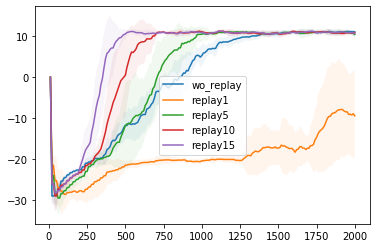

# Q1: If using replay is so good, why in the case of `n_sample` = 1 it doesn't perform as well?

Describe here ...